In this notebook we will study the energy conservation properties of several high-order methods for a system with the following Hamiltonian:
$$
\mathcal{H}\left(q_0,q_2,p_0,p_2\right) = \frac{A}{2} \left(p_0^2 + p_2^2 + q_0^2 + q_2^2\right) + \frac{B}{\sqrt{2}} q_0 \left(3q_2^2 - q_0^2\right) + \frac{D}{4} \left(q_0^2+q_2^2\right)^2
$$
This Hamiltonian resembles the Hénon-Heiles one, but it has an additional fourth order term.
The aim of this benchmark is to see what happens with the energy error when highly accurate solutions are needed and how the results compare with the Hénon-Heiles case.

In [1]:
using DifferentialEquations, Plots
using TaylorIntegration
pyplot()

T(p) = A / 2 * norm(p)^2
V(q) = A / 2 * (q[1]^2 + q[2]^2) + B / √2 * q[1] * (3 * q[2]^2 - q[1]^2) + D / 4 * (q[1]^2 + q[2]^2)^2
H(q, p) = T(p) + V(q)

const A, B, D = 1., 0.55, 0.4

module InPlace
using ParameterizedFunctions

function q̇(t, q, p, dq)
    dq[1] = A * p[1]
    dq[2] = A * p[2]
end

function ṗ(t, q, p, dp)
    dp[1] = -A * q[1] - 3 * B / √2 * (q[2]^2 - q[1]^2) - D * q[1] * (q[1]^2 + q[2]^2)
    dp[2] = -q[2] * (A + 3 * √2 * B * q[1] + D * (q[1]^2 + q[2]^2))
end

const A, B, D = 1., 0.55, 0.4

const q0 = [4.919080920016389, 2.836942666663649]
const p0 = [0., 0.]
const u0 = vcat(q0, p0)

h_eqs = @ode_def_noinvjac HamiltEqs begin
  dq₀ = A * p₀
  dq₂ = A * p₂
  dp₀ = -A * q₀ - 3 * B / √2 * (q₂^2 - q₀^2) - D * q₀ * (q₀^2 + q₂^2)
  dp₂ = -q₂ * (A + 3 * √2 * B * q₀ + D * (q₀^2 + q₂^2))
end A=>1 B=>0.55 D=>0.4

end

module OutOfPlace
using StaticArrays

function q̇(t, q, p)
    p
end

function ṗ(t, q, p)
    dp1 = -A * q[1] - 3 * B / √2 * (q[2]^2 - q[1]^2) - D * q[1] * (q[1]^2 + q[2]^2)
    dp2 = -q[2] * (A + 3 * √2 * B * q[1] + D * (q[1]^2 + q[2]^2))
    @SVector [dp1, dp2]
end

const A, B, D = 1., 0.55, 0.4

const q0 = @SVector [4.919080920016389, 2.836942666663649]
const p0 = @SVector [0., 0.]
const u0 = vcat(q0, p0)

h_eqs(t, z) = SVector(
    z[3],
    z[4],
    -A * z[1] - 3 * B / √2 * (z[2]^2 - z[1]^2) - D * z[1] * (z[1]^2 + z[2]^2), 
    -z[2] * (A + 3 * √2 * B * z[1] + D * (z[1]^2 + z[2]^2))
)

end

function g(u, resid)
    resid[1] = H([u[1],u[2]],[u[3],u[4]]) - E
    resid[2:4] .= 0
end

const cb = ManifoldProjection(g, nlopts=Dict(:ftol=>1e-13))

const E = H(InPlace.q0, InPlace.p0)

119.99999999999999

For the comparison we will use the following function

In [2]:
energy_err(sol) = map(i->H([sol[1,i], sol[2,i]], [sol[3,i], sol[4,i]])-E, 1:length(sol.u))
abs_energy_err(sol) = [abs.(H([sol[1,j], sol[2,j]], [sol[3,j], sol[4,j]]) - E) for j=1:length(sol.u)]

function compare(mode=InPlace, dyn_only=false, plt=nothing; tmax=1e2)
    prob1 = DynamicalODEProblem(mode.q̇, mode.ṗ, mode.q0, mode.p0, (0., tmax))
    if (mode == InPlace && !dyn_only)
        prob2 = ODEProblem(mode.h_eqs, mode.u0, (0., tmax))
    end
    gc()
    (mode == InPlace  && !dyn_only) && @time sol1 = solve(prob2, Vern9(), callback=cb, abstol=1e-14, reltol=1e-14)
    @time sol2 = solve(prob1, KahanLi8(), dt=1e-2, maxiters=1e10)
    @time sol3 = solve(prob1, SofSpa10(), dt=1e-2)
    @time sol4 = solve(prob1, Vern9(), abstol=1e-14, reltol=1e-14)
    @time sol5 = solve(prob1, DPRKN12(), abstol=1e-14, reltol=1e-14)
    (mode == InPlace && !dyn_only) && @time sol6 = solve(prob2, TaylorMethod(50), abstol=1e-20)
    
    (mode == InPlace && !dyn_only) && println("Vern9 + ManifoldProjection max energy error: ", maximum(abs_energy_err(sol1)))
    println("KahanLi8 max energy error: ",                   maximum(abs_energy_err(sol2)))
    println("SofSpa10 max energy error: ",                   maximum(abs_energy_err(sol3)))
    println("Vern9 max energy error: ",                      maximum(abs_energy_err(sol4)))
    println("DPRKN12 max energy error: ",                    maximum(abs_energy_err(sol5)))
    (mode == InPlace && !dyn_only) && println("TaylorMethod max energy error: ",               maximum(abs_energy_err(sol6)))
    
    if plt == nothing
        plt = plot(xlabel="t", ylabel="Energy error")
    end
    (mode == InPlace && !dyn_only) && plot!(sol1.t, energy_err(sol1), label="Vern9 + ManifoldProjection")
    plot!(sol2.t, energy_err(sol2), label="KahanLi8", ls=mode==InPlace?:solid : :dash)
    plot!(sol3.t, energy_err(sol3), label="SofSpa10", ls=mode==InPlace?:solid : :dash)
    plot!(sol4.t, energy_err(sol4), label="Vern9", ls=mode==InPlace?:solid : :dash)
    plot!(sol5.t, energy_err(sol5), label="DPRKN12", ls=mode==InPlace?:solid : :dash)
    (mode == InPlace && !dyn_only) && plot!(sol6.t, energy_err(sol6), label="TaylorMethod")
    
    return plt
end

compare (generic function with 4 methods)

Note: The `NLsolve` call used by `ManifoldProjection` was modified to use `ftol=1e-13` in order to obtain a very low energy error. 

  0.062707 seconds (297.65 k allocations: 44.535 MiB, 24.61% gc time)
  0.011268 seconds (190.21 k allocations: 10.319 MiB)
  0.017977 seconds (190.20 k allocations: 10.319 MiB)
  0.195049 seconds (7.53 M allocations: 128.667 MiB, 47.34% gc time)
  0.003146 seconds (48.76 k allocations: 2.102 MiB)
  0.393643 seconds (1.83 M allocations: 299.363 MiB, 62.82% gc time)
Vern9 + ManifoldProjection max energy error: 9.947598300641403e-14
KahanLi8 max energy error: 5.5706550483591855e-12
SofSpa10 max energy error: 3.836930773104541e-12
Vern9 max energy error: 3.680611371237319e-12
DPRKN12 max energy error: 6.394884621840902e-13
TaylorMethod max energy error: 4.831690603168681e-13



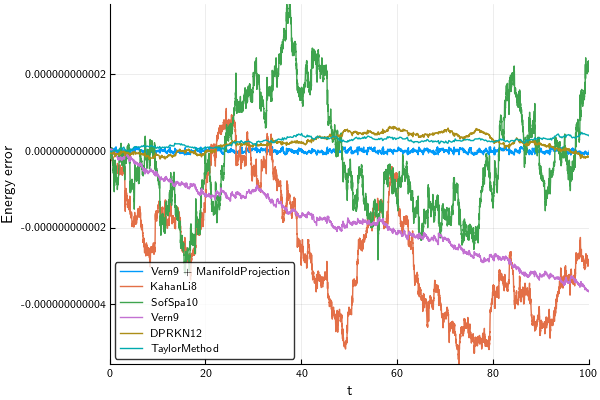

In [4]:
compare(tmax=1e2)

  0.828742 seconds (2.97 M allocations: 443.164 MiB, 44.34% gc time)
  0.383049 seconds (1.90 M allocations: 101.091 MiB, 68.74% gc time)
  0.461186 seconds (1.90 M allocations: 101.091 MiB, 60.10% gc time)
  3.458478 seconds (75.54 M allocations: 1.260 GiB, 68.34% gc time)
  0.051792 seconds (482.63 k allocations: 21.510 MiB, 33.05% gc time)
  2.437820 seconds (18.30 M allocations: 2.589 GiB, 42.47% gc time)
Vern9 + ManifoldProjection max energy error: 9.947598300641403e-14
KahanLi8 max energy error: 1.0530243343964685e-11
SofSpa10 max energy error: 1.5077716852829326e-11
Vern9 max energy error: 4.992273261450464e-11
DPRKN12 max energy error: 2.2453150450019166e-12
TaylorMethod max energy error: 1.0089706847793423e-12



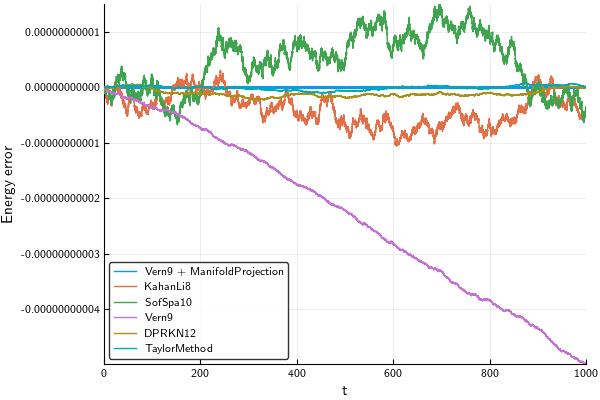

In [5]:
compare(tmax=1e3)

 14.575109 seconds (29.67 M allocations: 4.295 GiB, 66.22% gc time)
  3.383188 seconds (19.00 M allocations: 966.797 MiB, 66.69% gc time)
  4.607750 seconds (19.00 M allocations: 966.797 MiB, 61.22% gc time)
120.959136 seconds (755.18 M allocations: 12.566 GiB, 89.04% gc time)
  4.301123 seconds (4.82 M allocations: 206.832 MiB, 91.57% gc time)
 36.583572 seconds (182.98 M allocations: 25.553 GiB, 59.39% gc time)
Vern9 + ManifoldProjection max energy error: 9.947598300641403e-14
KahanLi8 max energy error: 4.3968384488835e-11
SofSpa10 max energy error: 6.492939519375795e-11
Vern9 max energy error: 4.914255669064005e-10
DPRKN12 max energy error: 3.673505943879718e-11
TaylorMethod max energy error: 5.073275133327115e-12



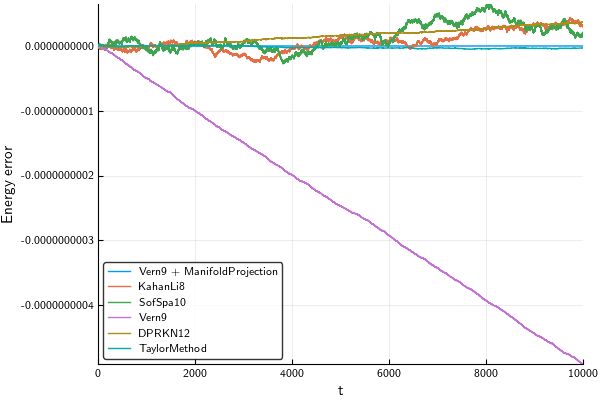

In [6]:
compare(tmax=1e4)

In [ ]:
compare(tmax=2e4)

As we can see from the above plots, the only method that can give a very low energy error for long time simulation is the manifold projection one. In comparison with the Hénon-Heiles system we see that as the Hamiltonian got more complex, the energy error for the other integration methods increased significantly.

In [7]:
function in_vs_out(;dyn_only=true, tmax=1e2)
    println("In place versions:")
    plt = compare(InPlace, dyn_only, tmax=tmax)
    println("\nOut of place versions:")
    plt = compare(OutOfPlace, false, plt; tmax=tmax)
end

in_vs_out (generic function with 1 method)

In place versions:
  0.888909 seconds (2.97 M allocations: 443.164 MiB, 43.89% gc time)
  0.398888 seconds (1.90 M allocations: 101.091 MiB, 67.46% gc time)
  0.482330 seconds (1.90 M allocations: 101.091 MiB, 59.62% gc time)
  3.731503 seconds (75.54 M allocations: 1.260 GiB, 66.58% gc time)
  0.053693 seconds (482.63 k allocations: 21.510 MiB, 34.86% gc time)
  2.500785 seconds (18.30 M allocations: 2.589 GiB, 43.96% gc time)
Vern9 + ManifoldProjection max energy error: 9.947598300641403e-14
KahanLi8 max energy error: 1.0530243343964685e-11
SofSpa10 max energy error: 1.5077716852829326e-11
Vern9 max energy error: 4.992273261450464e-11
DPRKN12 max energy error: 2.2453150450019166e-12
TaylorMethod max energy error: 1.0089706847793423e-12

Out of place versions:
  0.084203 seconds (200.20 k allocations: 26.270 MiB, 6.14% gc time)
  0.148125 seconds (200.20 k allocations: 26.271 MiB, 5.66% gc time)
  0.099269 seconds (580.67 k allocations: 49.102 MiB, 20.41% gc time)
  0.060579 seconds (


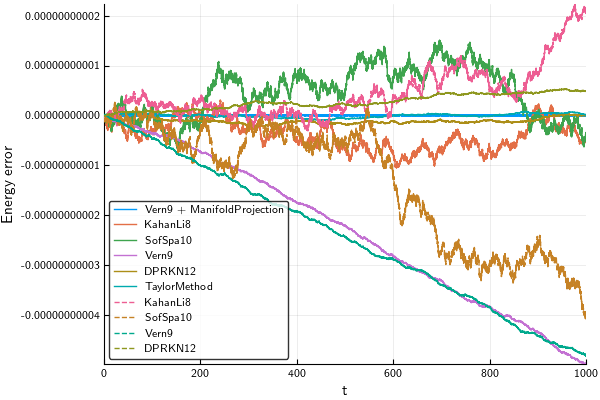

In [9]:
in_vs_out(dyn_only=false, tmax=1e3)

In place versions:
  0.011679 seconds (190.21 k allocations: 10.319 MiB)
  0.019200 seconds (190.20 k allocations: 10.319 MiB)
  0.201068 seconds (7.53 M allocations: 128.667 MiB, 43.96% gc time)
  0.003851 seconds (48.76 k allocations: 2.102 MiB)
KahanLi8 max energy error: 5.5706550483591855e-12
SofSpa10 max energy error: 3.836930773104541e-12
Vern9 max energy error: 3.680611371237319e-12
DPRKN12 max energy error: 6.394884621840902e-13

Out of place versions:
  0.007844 seconds (20.19 k allocations: 3.287 MiB)
  0.014908 seconds (20.18 k allocations: 3.288 MiB)
  0.008748 seconds (58.56 k allocations: 5.219 MiB)
  0.002623 seconds (24.51 k allocations: 1.213 MiB)
KahanLi8 max energy error: 5.229594535194337e-12
SofSpa10 max energy error: 4.007461029686965e-12
Vern9 max energy error: 4.746425474877469e-12
DPRKN12 max energy error: 9.521272659185342e-13



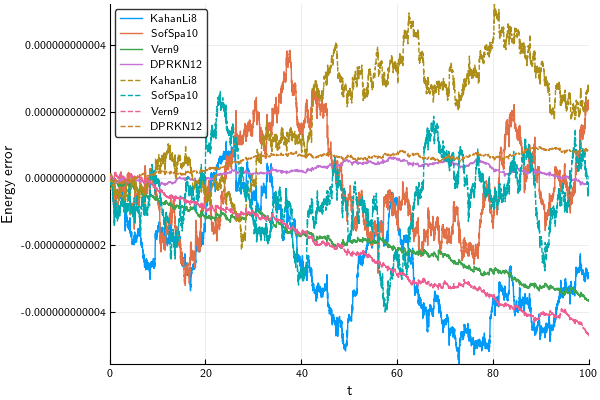

In [10]:
in_vs_out(tmax=1e2)

In place versions:
  0.263914 seconds (1.90 M allocations: 101.091 MiB, 50.92% gc time)
  0.520502 seconds (1.90 M allocations: 101.091 MiB, 60.82% gc time)
  3.796145 seconds (75.54 M allocations: 1.260 GiB, 65.74% gc time)
  0.052240 seconds (482.63 k allocations: 21.510 MiB, 32.17% gc time)
KahanLi8 max energy error: 1.0530243343964685e-11
SofSpa10 max energy error: 1.5077716852829326e-11
Vern9 max energy error: 4.992273261450464e-11
DPRKN12 max energy error: 2.2453150450019166e-12

Out of place versions:
  0.082446 seconds (200.20 k allocations: 26.270 MiB, 6.26% gc time)
  0.148955 seconds (200.20 k allocations: 26.271 MiB, 5.40% gc time)
  0.104749 seconds (580.67 k allocations: 49.102 MiB, 19.51% gc time)
  0.062974 seconds (240.34 k allocations: 13.194 MiB, 55.92% gc time)
KahanLi8 max energy error: 2.2353674467012752e-11
SofSpa10 max energy error: 4.079936388734495e-11
Vern9 max energy error: 4.828848432225641e-11
DPRKN12 max energy error: 5.3859139370615594e-12



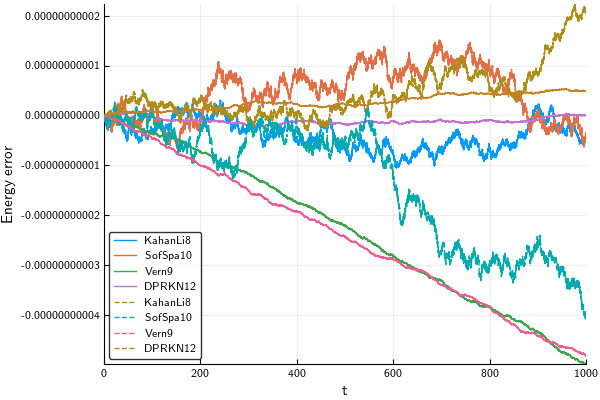

In [11]:
in_vs_out(tmax=1e3)

In place versions:
  2.616403 seconds (19.00 M allocations: 966.797 MiB, 47.56% gc time)
  4.231985 seconds (19.00 M allocations: 966.797 MiB, 51.45% gc time)
110.784146 seconds (755.18 M allocations: 12.566 GiB, 85.16% gc time)
  8.979939 seconds (4.82 M allocations: 206.832 MiB, 95.85% gc time)
KahanLi8 max energy error: 4.3968384488835e-11
SofSpa10 max energy error: 6.492939519375795e-11
Vern9 max energy error: 4.914255669064005e-10
DPRKN12 max energy error: 3.673505943879718e-11

Out of place versions:
  1.024597 seconds (2.00 M allocations: 208.599 MiB, 23.38% gc time)
  1.568905 seconds (2.00 M allocations: 212.600 MiB, 12.64% gc time)
  1.060547 seconds (5.79 M allocations: 461.987 MiB, 22.01% gc time)
  0.277695 seconds (2.40 M allocations: 114.698 MiB)
KahanLi8 max energy error: 3.595346242946107e-11
SofSpa10 max energy error: 8.72120153871947e-11
Vern9 max energy error: 5.113633960718289e-10
DPRKN12 max energy error: 2.41158204516978e-11



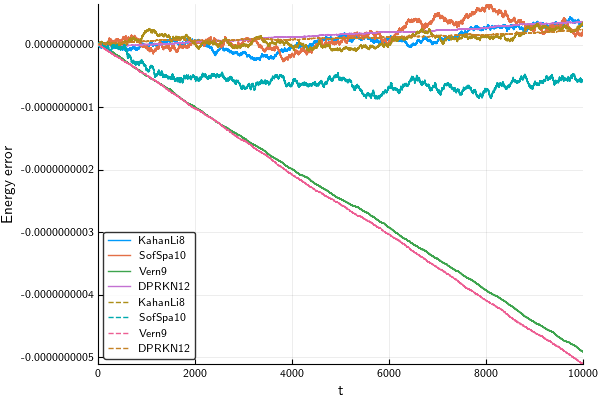

In [12]:
in_vs_out(tmax=1e4)